In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from nltk import word_tokenize
import pandas as pd
import numpy as np
import re

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Read CSV files
train = pd.read_csv("/content/drive/MyDrive/Dataset/SoftCom/daraz_comment_train1_4k.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/SoftCom/daraz_comment_test600.csv")

In [ ]:
# Install necessary packages
!pip install torch
!pip install nltk

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Download NLTK data
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Load the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        lstm_out, _ = self.lstm(dropped)
        output = self.fc(lstm_out[:, -1, :])
        return output


In [ ]:
# Tokenize and pad the input sequences for LSTM
def preprocess_data_lstm(data, tokenizer):
    sequences = [word_tokenize(text) for text in data['text'].values]
    sequences = [tokenizer.convert_tokens_to_ids(seq) for seq in sequences]
    padded_sequences = pad_sequence([torch.LongTensor(seq) for seq in sequences], batch_first=True)
    return padded_sequences

In [ ]:
# Convert labels to one-hot encoding
y_train = train['label'].astype(int).values
y_test = test['label'].astype(int).values

In [ ]:
MAX_SEQUENCE_LENGTH = 400

In [ ]:
# Tokenize and pad the input sequences using BERT tokenizer
train_data_lstm = preprocess_data_lstm(train, tokenizer)
test_data_lstm = preprocess_data_lstm(test, tokenizer)

In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor_lstm = torch.tensor(train_data_lstm)
y_train_tensor_lstm = torch.tensor(y_train, dtype=torch.long)  # Adjust labels
X_test_tensor_lstm = torch.tensor(test_data_lstm)
y_test_tensor_lstm = torch.tensor(y_test, dtype=torch.long)    # Adjust labels

<ipython-input-15-e40843fa7117>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor_lstm = torch.tensor(train_data_lstm)
<ipython-input-15-e40843fa7117>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor_lstm = torch.tensor(test_data_lstm)


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Create the PyTorch model
vocab_size = len(tokenizer.get_vocab())
embedding_dim = 768
hidden_size = 512
output_size = 5

# Create the PyTorch LSTM model
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_size, output_size)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Define the loss and optimizer
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.AdamW(lstm_model.parameters(), lr=1e-5)

In [ ]:
unique_labels = train['label'].unique()
print("Unique labels:", unique_labels)


Unique labels: [4 5 3 2 1]


In [ ]:
ulabels = test['label'].unique()
print("Unique labels:", ulabels)

Unique labels: [2 1 3 5 4]


In [ ]:
label_distribution = train['label'].value_counts()
print("Label distribution:\n", label_distribution)


Label distribution:
 label
4    659
5    494
3    132
1     62
2     52
Name: count, dtype: int64


In [ ]:
train.head()

,text,label
0,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন,4
1,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...,5
2,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...,3
3,খুবই চমৎকার একটা ঘড়ি। ধন্যবাদ,5
4,অনেক সুন্দর চোখ বুঝে নিতে পারেন,5


In [ ]:
test.head()

,text,label
0,চাইলাম একটা দিয়ে দিসে আরেকটা তা আবার xxl মতো p...,2
1,"অর্ডার করেছিলাম XXL পেয়েছি M সাইজ,, এইটা করলে ...",2
2,একেবারে বাজে কাপড় খুবই নরমাল সুতা সব খুলে গেছে...,2
3,কি আর বলবো ভাই।একেবারে ফালতু একটা t-shirt দিছে...,1
4,"ফালতু টি শার্ট, স্পট ভরা,লম্বা কালো দাগ, কেউ ন...",1


In [ ]:
print(X_train_tensor_lstm[:5])  # Print the first 5 rows


tensor([[  100,   100,   100,   100,   100,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  100,   100,   100, 12051,   100,   100,   100,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0, 

In [ ]:
# Convert labels to start from 0
y_train_tensor_lstm -= 1
y_test_tensor_lstm -= 1

# Training loop for LSTM
num_epochs = 2
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor_lstm), batch_size):
        inputs = X_train_tensor_lstm[i:i+batch_size]
        labels = y_train_tensor_lstm[i:i+batch_size]

        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)
        loss.backward()
        optimizer_lstm.step()


LSTM Model
  Loss: 1.702
  Accuracy: 0.316


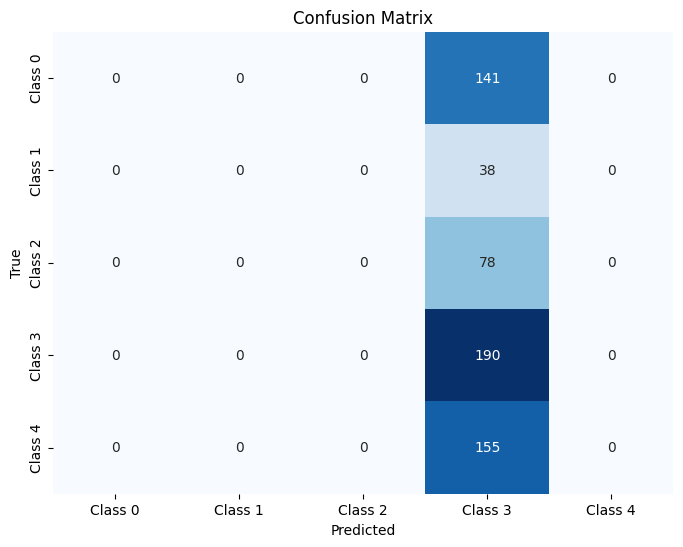


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       141
     Class 1       0.00      0.00      0.00        38
     Class 2       0.00      0.00      0.00        78
     Class 3       0.32      1.00      0.48       190
     Class 4       0.00      0.00      0.00       155

    accuracy                           0.32       602
   macro avg       0.06      0.20      0.10       602
weighted avg       0.10      0.32      0.15       602



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the LSTM model
lstm_model.eval()
with torch.no_grad():
    outputs_lstm = lstm_model(X_test_tensor_lstm)
    predicted_labels_lstm = torch.argmax(outputs_lstm, dim=1)

# Convert tensors to numpy arrays
y_true_lstm = y_test_tensor_lstm.numpy()
y_pred_lstm = predicted_labels_lstm.numpy()

# Print loss and accuracy
loss_lstm = criterion_lstm(outputs_lstm, y_test_tensor_lstm).item()
accuracy_lstm = (predicted_labels_lstm == y_test_tensor_lstm).sum().item() / len(y_test_tensor_lstm)
print(f'LSTM Model\n  Loss: {loss_lstm:.3f}\n  Accuracy: {accuracy_lstm:.3f}')

# Create confusion matrix
cm = confusion_matrix(y_true_lstm, y_pred_lstm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, and F1 score
classification_rep_lstm = classification_report(y_true_lstm, y_pred_lstm, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("\nClassification Report:")
print(classification_rep_lstm)


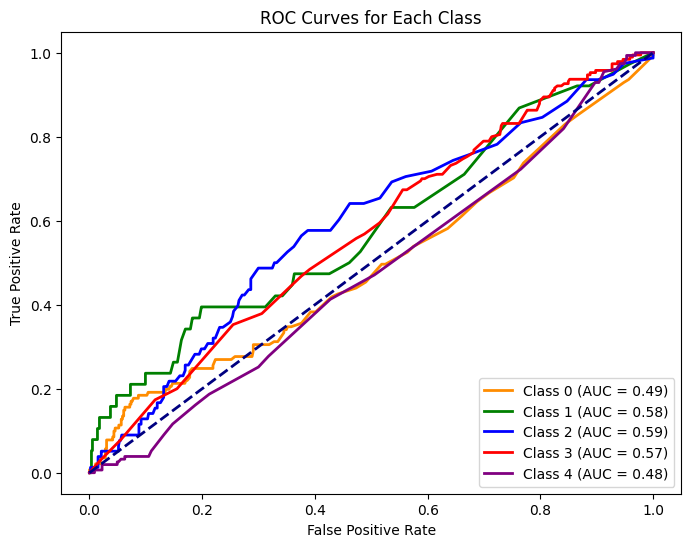

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test set
lstm_model.eval()
with torch.no_grad():
    outputs = lstm_model(X_test_tensor_lstm)

# Assuming you are interested in the scores for class 1 (change this if necessary)
predicted_scores = outputs[:, 1].numpy()

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(outputs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve((y_test_tensor_lstm == i).numpy(), outputs[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue', 'red', 'purple']  # Add more colors if needed

for i in range(outputs.shape[1]):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()
